MLP model for predicting (filtered) shear stress



> Input: Features {'freqQAmpI_filt', 'V_filt', 'maxFreqI_filt'} at p previous timesteps [(t-p), ... , (t-2), (t-1), t]


> Output: Shear Stress at one timestep [t]



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix-1, -1]  #last column is assumed to be the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel()})  
df = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3787:136186].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3787:136186].ravel()})

df = pd.concat([df, df2], axis=1)

df = df[['freqQAmpI_filt', 'V_filt', 'maxFreqI_filt', 'SS']]
print("Input data:\n", df)


Input data:
         freqQAmpI_filt       V_filt  maxFreqI_filt        SS
0         31438.277060  5489.978529  457680.400524  5.656166
1         31421.341616  5489.981454  457727.638932  5.657157
2         31409.798761  5489.997639  457770.778724  5.658317
3         31398.815589  5490.007016  457811.889181  5.659499
4         31395.584981  5490.000189  457775.514596  5.660404
...                ...          ...            ...       ...
132394    31041.955345  5459.380488  454414.128118  5.471059
132395    31035.059531  5459.377762  454404.028108  5.474545
132396    31020.001291  5459.388352  454403.709700  5.478286
132397    31012.016780  5459.398820  454398.871858  5.481751
132398    31010.874482  5459.399041  454410.333590  5.484813

[132399 rows x 4 columns]


In [4]:
# Preprocessing

#df = df.drop(['Time', 'Vel_der', 'T_der', 'Vel_pc', 'T_pc'], axis=1)   # Drop irrelevant features

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D (for input layer)

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))


Features shape, X =  (132100, 300, 3)
Target shape, Y =  (132100,)
After reshaping, X =  (132100, 900)


In [5]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])


Training samples: 95112
Validation samples: 10568
Testing samples: 26420


Epoch 1/20
2973/2973 [==============================] - 7s 2ms/step - loss: 0.3049 - val_loss: 0.1022
Epoch 2/20
2973/2973 [==============================] - 7s 2ms/step - loss: 0.0310 - val_loss: 0.0043
Epoch 3/20
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 4/20
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 5/20
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 6/20
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 7/20
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 8/20
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/20
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/20
2973/2973 [==============================] - 6s 2ms/step - loss: 0.001

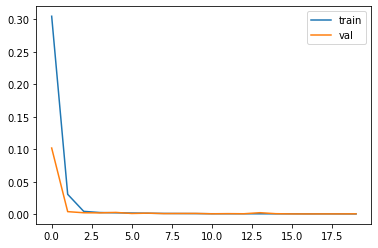

---Training time: 128.45419645 seconds ---


In [6]:
# Build the model

np.random.seed(0)   # To get reproducible results
tf.random.set_seed(0)

model = Sequential()
model.add(Dense(128, kernel_initializer = 'normal', input_dim = in_dim, activation='relu'))
model.add(Dense(64, kernel_initializer = 'normal', activation='relu'))
model.add(Dense(32, kernel_initializer = 'normal', activation='relu'))
model.add(Dense(1, kernel_initializer = 'normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


In [7]:
# Save the model

print(model.summary())
#model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/MLP_ss.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               115328    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 125,697
Trainable params: 125,697
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# Evaluate the model

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_r2, val_r2, test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(train_rmse, val_rmse, test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


R2 scores: Train - 0.95806, Validation - 0.95700, Test - 0.91001
RMSE scores: Train - 0.02633, Validation - 0.03060, Test - 0.04335

---Time for Test data prediction: 0.81350970 seconds ---


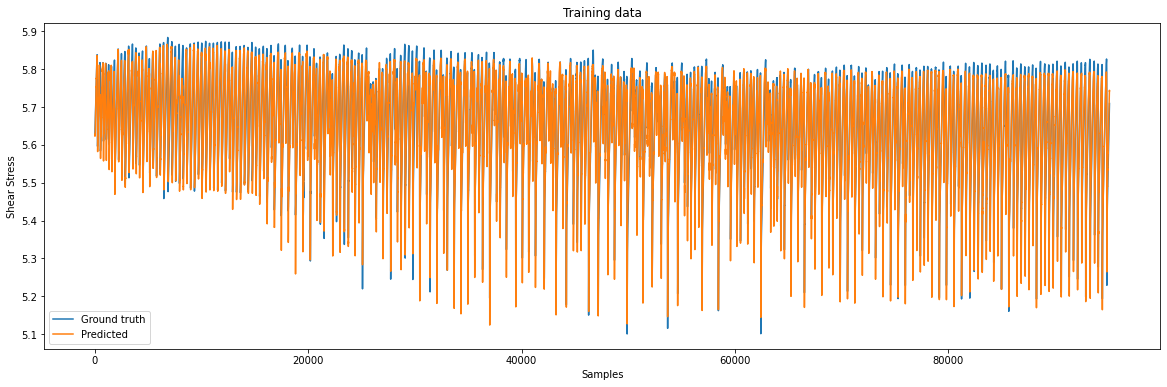

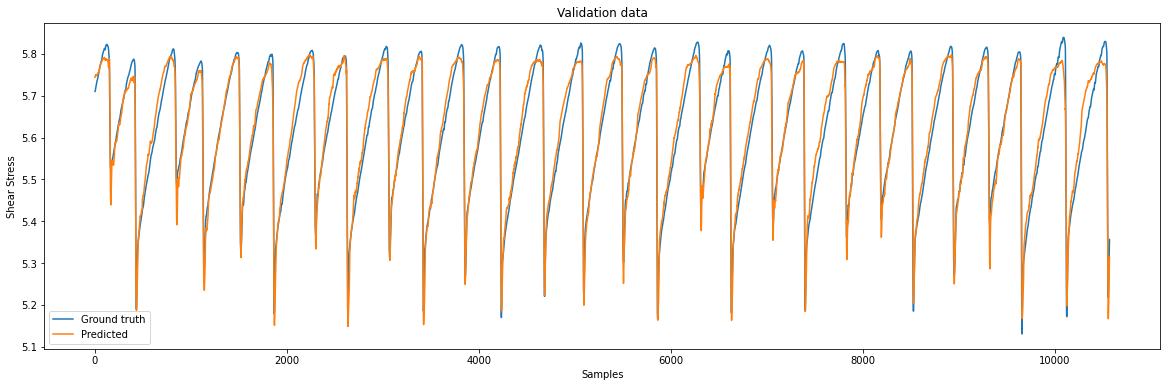

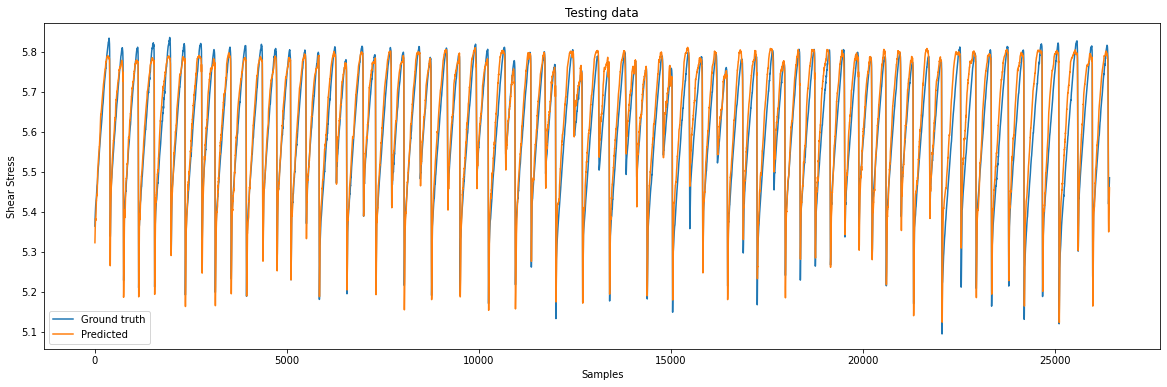

In [9]:
# Results plot

def results_plot(fig_no, gt, pred, title):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Samples')
  plt.ylabel('Shear Stress')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train, y_predTrain, 'Training data')
results_plot(2, Y_val, y_predVal, 'Validation data')
results_plot(3, y_test, y_predTest, 'Testing data')


Text(0.5, 1.0, 'Detailed View, Testing Data')

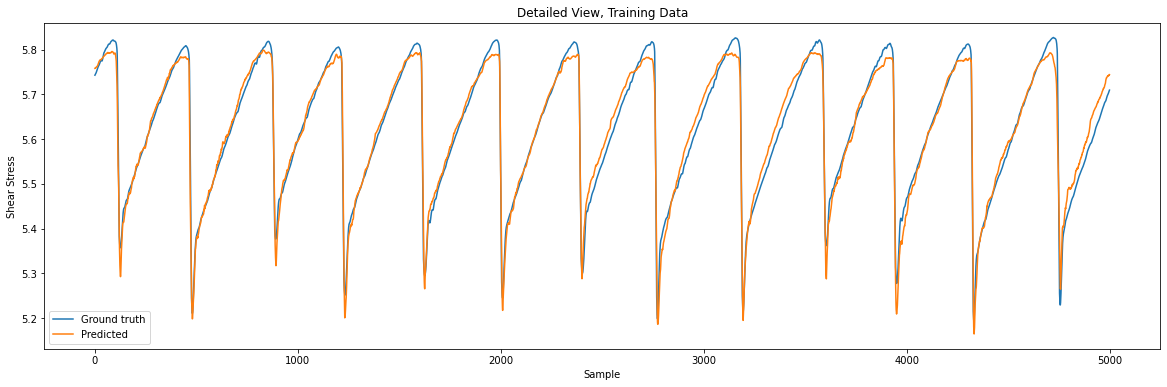

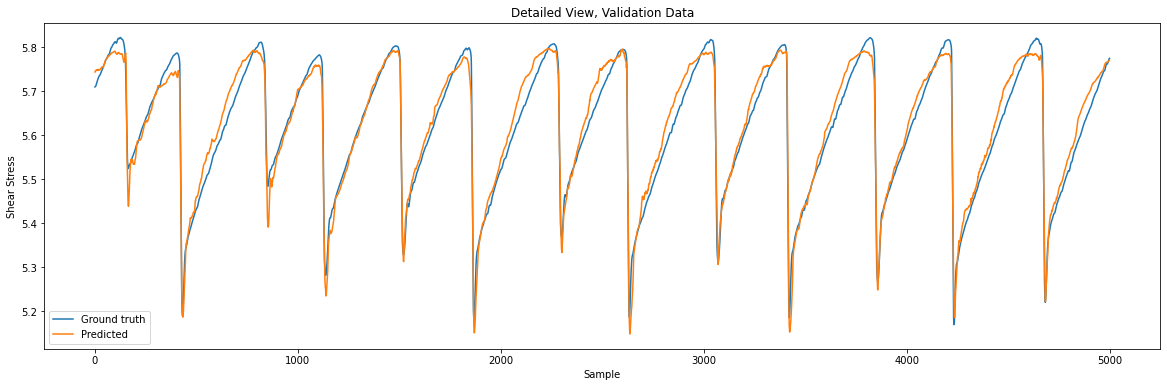

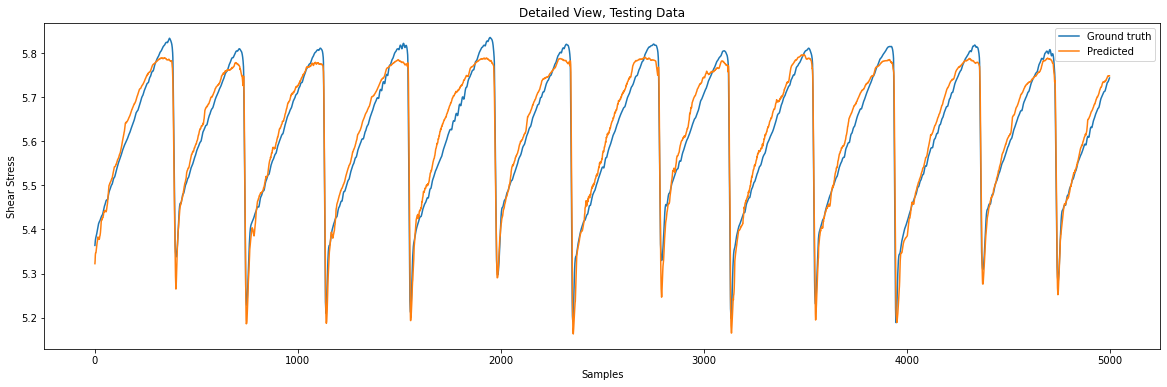

In [10]:
# Detailed view of the plots

n=5000

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-n:])
plt.plot(y_predTrain[-n:])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:n])
plt.plot(y_predVal[:n])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:n])
plt.plot(y_predTest[:n])
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'Shear Stress')

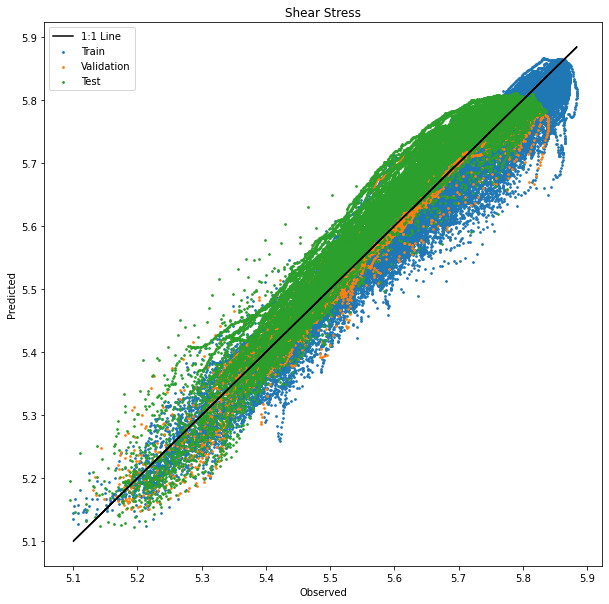

In [11]:

# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train, Y_train, 'black')
plt.scatter(Y_train, y_predTrain, s=3)
plt.scatter(Y_val, y_predVal, s=3)
plt.scatter(y_test, y_predTest, s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('Shear Stress')
